<a href="https://colab.research.google.com/github/VitorSRamos/III_LeGaC_Hands_On/blob/main/LensModelingWithSBI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Lens Modeling with Simulation-Based Inference**


This activity was created for a Hands-On session for the 3rd workshop on Lensing by Galaxies and Clusters (III LeGaC). The goal of this tutorial is to use simulation-based inference to measure the Einstein Radii of a dataset of galaxy-galaxy strong lensing images.

In [ ]:
# basic imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# setting random state
np.random.seed(42)

Simulating Galaxy-Galaxy Strong Lensing systems
--
The first step is to simulate images of Strong Lensing systems. We'll use [deeplenstronomy](https://github.com/deepskies/deeplenstronomy) to generate a dataset of simple SL simulations.

To use deeplenstronomy, we first need a configuration file that tells the simulator what parameters to use to generate the simulations. For this tutorial, we'll generate a dataset of 2000 galaxy-galaxy strong lensing systems. The file specifies the parameters used to generate simulations, including both interest and nuisance parameters, and some observation parameters. For more information on deeplenstronomy configuration files, see [here](https://github.com/deepskies/deeplenstronomy/blob/master/Notebooks/ConfigFiles.md).

In [ ]:
# Downloading custom configuration file for the simulator
!wget -q https://raw.githubusercontent.com/VitorSRamos/III_LeGaC_Hand_On/main/training_configuration_file.yaml

In [ ]:
# Installing the simulator
!pip install deeplenstronomy --quiet

In [ ]:
import deeplenstronomy
import deeplenstronomy.deeplenstronomy as dl

In [ ]:
training_dataset = dl.make_dataset("training_configuration_file.yaml", verbose=True)

Entering main organization loop
Organizing CONFIGURATION_1
Generating images for CONFIGURATION_1
	Progress: 100.0 %  ---  Elapsed Time: 0 H 2 M 18 S         


The simulator outputs a numpy array with the images that we'll store in the `training_images` variable, and a dataframe with the parameters, stored as `training_params`.


In [ ]:
training_images=training_dataset.CONFIGURATION_1_images
training_params=training_dataset.CONFIGURATION_1_metadata

print(f"Training images shape: {training_images.shape}")
print(f"Training Parameters shape: {training_params.shape}")

Training images shape: (4000, 4, 87, 87)
Training Parameters shape: (4000, 248)


In [ ]:
training_params.head()

,OBJID-g,H0-g,Om0-g,exposure_time-g,numPix-g,pixel_scale-g,psf_type-g,read_noise-g,ccd_gain-g,seeing-g,...,PLANE_2-OBJECT_1-MASS_PROFILE_1-center_y-z,BACKGROUND_IDX-z,PLANE_1-REDSHIFT-g,PLANE_2-REDSHIFT-g,PLANE_1-REDSHIFT-r,PLANE_2-REDSHIFT-r,PLANE_1-REDSHIFT-i,PLANE_2-REDSHIFT-i,PLANE_1-REDSHIFT-z,PLANE_2-REDSHIFT-z
0,1,70.0,0.3,120.667,87,0.263,GAUSSIAN,7,4,0.890,...,-1.435008,0,0.729251,2.015700,0.729251,2.015700,0.729251,2.015700,0.729251,2.015700
1,2,70.0,0.3,163.333,87,0.263,GAUSSIAN,7,4,1.175,...,-0.187526,0,0.550267,5.919574,0.550267,5.919574,0.550267,5.919574,0.550267,5.919574
2,3,70.0,0.3,46.000,87,0.263,GAUSSIAN,7,4,1.104,...,0.052703,0,0.480304,1.915357,0.480304,1.915357,0.480304,1.915357,0.480304,1.915357
3,4,70.0,0.3,195.333,87,0.263,GAUSSIAN,7,4,1.246,...,0.861323,0,0.430166,3.175774,0.430166,3.175774,0.430166,3.175774,0.430166,3.175774
4,5,70.0,0.3,120.667,87,0.263,GAUSSIAN,7,4,1.531,...,-0.496647,0,0.866492,3.357734,0.866492,3.357734,0.866492,3.357734,0.866492,3.357734


Einstein Radius: 1.889130214708865 arcsec


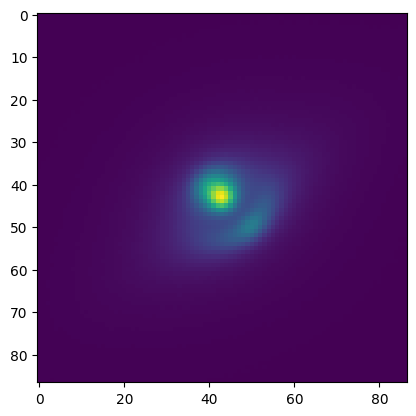

In [ ]:
image_idx = 3
print(f"Einstein Radius: {training_params['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'][idx]} arcsec")

# plot
fig, axs = plt.subplots(1,4, figsize=(15,8))
for ax_idx, ax in enumerate(axs.ravel()):
    ax.imshow(training_images[image_idx, ax_idx])

Simulation-Based Inference
--

Now that we have the simulations, we can focus on the machine learning model that will be used for the inference procedure. [Simulation-Based Inference](https://www.pnas.org/doi/10.1073/pnas.1912789117) (SBI) is a form of likelihood-free inference that allows us to perform statistical analysis and make predictions without explicitly specifying a likelihood function. By using density estimation algorithms such as normalizing flows and mixture density networks, we can effectively learn the underlying relationships between the observed data and the model parameters, enabling us to infer the posterior distributions for these parameters.

One way to perform SBI is by using [Neural Posterior Estimation](https://arxiv.org/abs/1905.07488) (NPE), a technique that uses neural network based density estimators to approximate the posterior distribution directly from observed data. Rather than relying on traditional Markov Chain Monte Carlo (MCMC) methods, which can be computationally intensive and slow to converge, NPE directly targets the posterior distribution of the parameters, offering great scalability to high-dimensional parameter spaces and faster inference times. By training the neural network on a dataset generated from simulations, it learns to capture the relation between observed data and underlying parameters, allowing for posterior approximation.

To perform NPE on our data, we'll use the [sbi](https://github.com/sbi-dev/sbi) package.

In [ ]:
# Installing the inference package
!pip install sbi --quiet

In [ ]:
# some other useful imports
import torch

import sbi
from sbi import utils as utils
from sbi.inference import SNPE
from sbi.neural_nets.embedding_nets import CNNEmbedding
from sbi.utils.user_input_checks_utils import float32

To avoid working with high-dimensional image data, we can use an embedding network that summarizes the features in the images into lower dimensional vectors, reducing training and inference times and making the model less susceptible to small variations in training data, offering greater robusticity.

For this notebook, we'll use a simple Convolutional Neural Network.

In [ ]:
embedding_net = CNNEmbedding(input_shape=(87,87),
                             in_channels=4,
                             out_channels_per_layer= [128,64,32],
                             num_conv_layers= 3,
                             num_linear_layers = 4,
                             num_linear_units = 256,
                             output_dim = 16,
                             kernel_size = 3,
                             pool_kernel_size = 2,
                            )

We can then define our density estimator. We will use [Normalizing Flows](https://arxiv.org/abs/1908.09257), a class of models that work by applying invertible and differentiable transformations to a simple base distribution with the goal of modeling an arbitrary complex distribution. The parameters of the transformations are defined by neural networks, which allows us to train these models to perform density estimation in a dataset.



For the transformations, we opt for [Neural Spline Flows](https://arxiv.org/abs/1906.04032) (NSF), a class of normalizing flows that retains great expressivity while being relatively simple to train.

In [ ]:
neural_posterior = utils.posterior_nn(model="nsf",
                                      embedding_net=embedding_net,
                                      hidden_features=8,
                                      num_transforms=2,
                                      )

We choose our inference method. As mentioned earlier, we use Neural Posterior Estimation (implemented as SNPE). This creates the base `inference` object that will be used from now on.

In [ ]:
inference = SNPE(density_estimator=neural_posterior, device="cuda")

We then convert the training data to torch tensors (as required by sbi). Since we are only interested in the Einstein Radius, the new `training_params` variable will have that information only.

In [ ]:
expanded_params=np.expand_dims(training_params['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'], axis=1) # another requirement of sbi

training_params = torch.tensor(expanded_params, dtype=float32, device="cuda")
training_images = torch.tensor(training_images, dtype=float32, device="cuda")

print(f"Training images shape: {training_images.shape}")
print(f"Training params shape: {training_params.shape}")

Training images shape: torch.Size([4000, 4, 87, 87])
Training params shape: torch.Size([4000, 1])


Now we load the training data to the `inference` object

In [ ]:
inference.append_simulations(training_params, training_images)

And finally, we perform the training procedure using the training data.

In [ ]:
density_estimator = inference.train(stop_after_epochs=20,
                                    max_num_epochs=200,
                                    training_batch_size=512,
                                    learning_rate=0.01,
                                    validation_fraction=0.1,
                                    )

 Neural network successfully converged after 44 epochs.

We analyze the training procedure

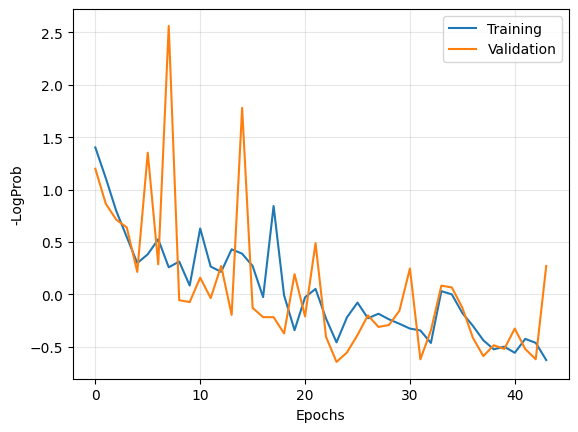

In [ ]:
# Creating training history object
training_history = inference._summary

plt.plot([-item for item in training_history["training_log_probs"]], label = "Training")
plt.plot([-item for item in training_history["validation_log_probs"]], label="Validation")
plt.xlabel("Epochs")
plt.ylabel("-LogProb")
plt.grid(alpha=0.3)
plt.legend()

With the density estimator trained, we can finally create the `posterior` object, capable of generating posterior distributions for new observations

In [ ]:
posterior = inference.build_posterior(density_estimator)

# Evaluating the trained model

To test how well our trained model works, we'll simulate a new dataset with the same parameter distributions but a different seed.

In [ ]:
# Downloading custom configuration file for the simulator
!wget -q https://raw.githubusercontent.com/VitorSRamos/III_LeGaC_Hand_On/main/test_configuration_file.yaml

In [ ]:
test_dataset = dl.make_dataset("test_configuration_file.yaml", verbose=True,)

Entering main organization loop
Organizing CONFIGURATION_1
Generating images for CONFIGURATION_1
	Progress: 100.0 %  ---  Elapsed Time: 0 H 0 M 44 S         


In [ ]:
test_images = torch.tensor(test_dataset.CONFIGURATION_1_images, device="cpu")
test_params = torch.tensor(np.expand_dims(test_dataset.CONFIGURATION_1_metadata["PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g"], axis=-1), device="cpu")

print(test_images.shape)
print(test_params.shape)

torch.Size([1000, 4, 87, 87])
torch.Size([1000, 1])


## Analyzing a single image
We start by analyzing the posterior distribution for a single image in the test set. We generate the posterior by

To build the posterior distribution for an observation, we pass the image to the posterior object and sample from the probability distribution. We can plot a histogram of the samples taken from the posterior to see what it looks like and compare it to the

In [ ]:
image_index = 3 # we pick an index for an element in the test set to analyze

samples = posterior.set_default_x(test_images[image_index]).sample((1000,), show_progress_bars=False).cpu()

In [ ]:
print(samples.shape)

torch.Size([1000, 1])


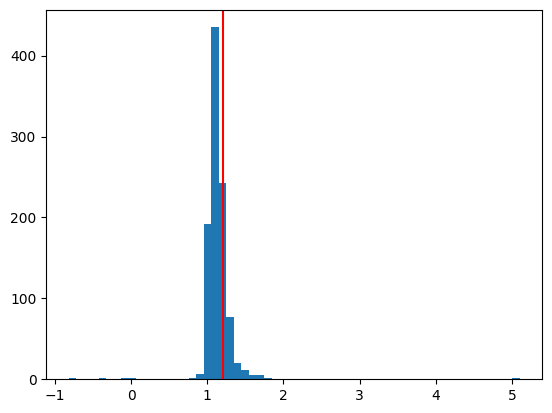

In [ ]:
plt.hist(samples[:,0], bins=60)
plt.axvline(test_params[image_index], color="red")

## Full Dataset
For the full dataset, we analyze the behavior of the posterior by looking at relevant statistics

In [ ]:
from scipy.stats import percentileofscore

In [ ]:
posterior_samples=[]
predictions = []
sigma_plus = []
sigma_minus = []
percentile_of_true=[]

for index, image in enumerate(test_images):
    samples = posterior.set_default_x(image).sample((500,), show_progress_bars=False).cpu() # the samples from each posterior
    posterior_samples.append(samples)
    predictions.append(np.median(samples.cpu())) # a list of the median value (interpreted as the model predictions)
    sigma_plus.append(np.quantile(samples, 0.84))
    sigma_minus.append(np.quantile(samples, 0.16))
    percentile_of_true.append(percentileofscore(samples[:,0], test_params[index])) # a list of the percentiles that contain the true value for each posterior

posterior_samples = np.stack(posterior_samples)
predictions = np.stack(predictions)

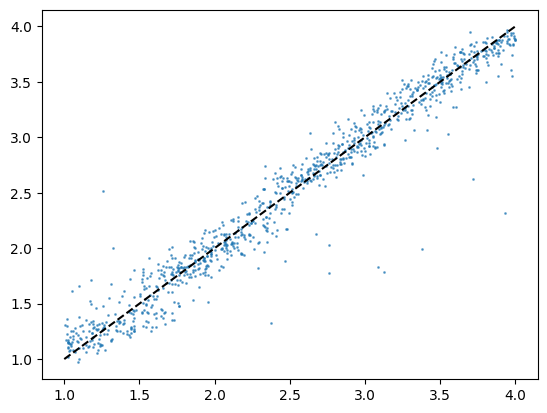

In [ ]:
plt.scatter(test_params.cpu(), predictions, s=1, alpha = 0.6)
plt.plot([1,4], [1,4], '--k')
plt.xlabel("True")
plt.ylabel("Predicted")

To analzse the uncertainties generated by the model, we need a more sophisticated plot

In [ ]:
results = pd.DataFrame(data={"True":test_params[:,0],
                             "Pred":predictions,
                             "sigma_plus":sigma_plus,
                             "sigma_minus":sigma_minus,
                             "percentile_of_true":percentile_of_true})
results.head()

,True,Pred,sigma_plus,sigma_minus,percentile_of_true
0,3.915886,3.791562,3.893259,3.669125,[89.60000000000001]
1,2.157942,1.981410,2.152805,1.796155,[85.0]
2,1.466169,1.274492,1.399068,1.130809,[91.80000000000001]
3,1.200764,1.131936,1.233279,1.038457,[76.0]
4,2.328618,2.195927,2.368743,2.019870,[77.4]


In [ ]:
binned_results = results.groupby(pd.cut(results["True"], 30)).agg('mean')
binned_results.head()

,True,Pred,sigma_plus,sigma_minus,percentile_of_true
True,,,,,
"(1.003, 1.106]",1.053272,1.194402,1.309080,1.083316,[18.91794871794872]
"(1.106, 1.205]",1.166491,1.254073,1.373758,1.117923,[37.90000000000002]
"(1.205, 1.305]",1.248023,1.296503,1.420097,1.154597,[51.85333333333333]
"(1.305, 1.405]",1.356637,1.378133,1.515965,1.202594,[56.91428571428572]
"(1.405, 1.505]",1.449813,1.371664,1.508863,1.192204,[70.36666666666667]


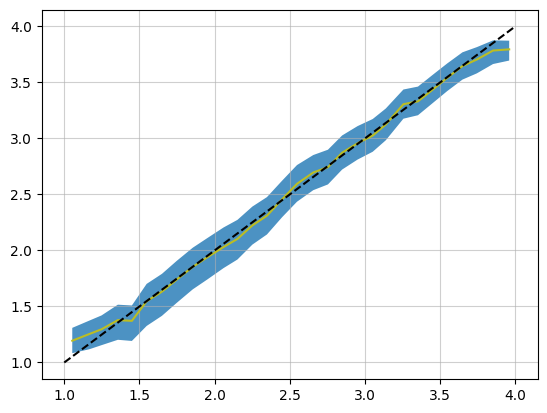

In [ ]:
plt.grid(alpha=0.6)
plt.fill_between(binned_results["True"], binned_results["sigma_minus"], binned_results["sigma_plus"], alpha=0.8)
plt.plot(binned_results["True"], binned_results["Pred"], color="C8")
plt.plot([1,4], [1,4], '--k')
plt.xlabel("True")
plt.ylabel("Predicted")

Finally, we can report some useful metrics

In [ ]:
def get_precision(pred, sig_p, sig_m):
    return 1 - (sig_p-sig_m)/pred

def get_deviation(pred, true):
    return (abs(pred-true))/pred

results["Precision"] = get_precision(results["Pred"], results["sigma_plus"], results["sigma_minus"])
results["Deviation"] = get_deviation(results["Pred"], results["True"])
results.head()

,True,Pred,sigma_plus,sigma_minus,percentile_of_true,Precision,Deviation
0,3.915886,3.791562,3.893259,3.669125,[89.60000000000001],0.940886,0.032790
1,2.157942,1.981410,2.152805,1.796155,[85.0],0.820002,0.089094
2,1.466169,1.274492,1.399068,1.130809,[91.80000000000001],0.789516,0.150395
3,1.200764,1.131936,1.233279,1.038457,[76.0],0.827886,0.060806
4,2.328618,2.195927,2.368743,2.019870,[77.4],0.841127,0.060426


In [ ]:
print(f"Median Precision: {results['Precision'].agg('mean')}")
print(f"Median Fractional Deviation: {results['Deviation'].agg('mean')}")

Median Precision: 0.8596027105560292
Median Fractional Deviation: 0.05625768812671993


## Simulation-Based Calibration
To assess the quality of the posteriors and the reliability of the uncertainties generated by the model, we can employ a few of tests know as [Simulation-Based Calibration](https://stat.paperswithcode.com/paper/validating-bayesian-inference-algorithms-with).

We start with the posterior coverage plot. For a well-calibrated model, the percentage of true values contained in a certain percentile range centered (around the median) should increase linearly as we increase the range. This ensures that the posteriors are not sistematically under- or over- confident.

[3, 24, 45, 70, 89, 108, 126, 153, 167, 189, 218, 243, 266, 292, 316, 336, 361, 383, 401, 419, 447, 472, 497, 521, 536, 561, 582, 601, 609, 630, 652, 670, 688, 706, 728, 744, 763, 785, 802, 823, 841, 860, 880, 901, 919, 933, 947, 970, 985, 1000]


Text(0, 0.5, 'Empirical Coverage')

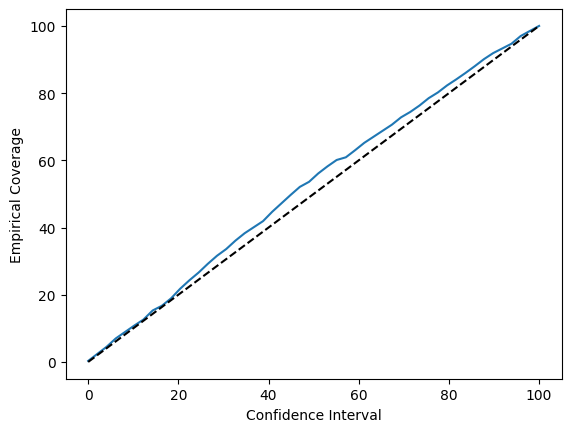

In [ ]:
# posterior coverage plot
confidence_intervals = np.linspace(0,50,50)

empirical_coverage=[]
for interval in confidence_intervals:
    coverage = 0
    for percentile in percentile_of_true:
        if percentile >= 50-interval and percentile <= 50+interval:
            coverage+=1
    empirical_coverage.append(coverage)

print(empirical_coverage)



plt.plot(2*confidence_intervals, [item/10 for item in empirical_coverage])
plt.plot([0,100], [0,100], '--k')
plt.xlabel("Confidence Interval")
plt.ylabel("Empirical Coverage")
plt.grid(alpha=0.3)

 The next tests are based on rank statistics. The rank of a posterior is found by counting how many of its samples fall under its true value. Thus, for a well-calibrated model, the distribution of rank values for a set of posteriors is expected to be uniform. The following tests probe how close the rank distribution is to a uniform distribution. We can use sbi's built-in functions for these tests.

In [ ]:
from sbi.analysis import run_sbc
from sbi.analysis import check_sbc, get_nltp, sbc_rank_plot

In [ ]:
ranks, dap_samples = sbi.analysis.run_sbc(test_params.cuda(), # ground-truth parameters for sbc, simulated from the prior
                                          test_images.cuda(), # observed data for sbc, simulated from thetas
                                          posterior, # a posterior obtained from sbi
                                          num_posterior_samples=1000
                                          )
# now running stats tests
check_stats = check_sbc(ranks,
                        test_params.cuda(),
                        dap_samples,
                        num_posterior_samples=1000
)

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

We start with the Kolmogorov-Smirnov p-values test, which checks the null-hypothesis that the samples in the rank distribution and a set of samples taken from a uniform distribution are sampled from the same distribution. We expect the result to be a non-vanishing probability.

In [ ]:
print(f"kolmogorov-smirnov p-values = {check_stats['ks_pvals'].numpy()}")

kolmogorov-smirnov p-values = [0.03378307]


The [Classifier two-sample](https://arxiv.org/abs/1610.06545) test compares the rank distribution to a uniform distribution by training a classifier to differentiate these two distributions. Scores close to 0.5 show that the classifier is unable to differentiate between the two distributions.

In [ ]:
print(f"c2st accuracies = {check_stats['c2st_ranks'].numpy()}")

c2st accuracies = [0.563]


Finally, we plot the ranks distribution. The gray region represents the 99% confidence interval for a uniform distribution, meaning that 1 in every 100 bars should fall outside of that region for any uniform distribution.

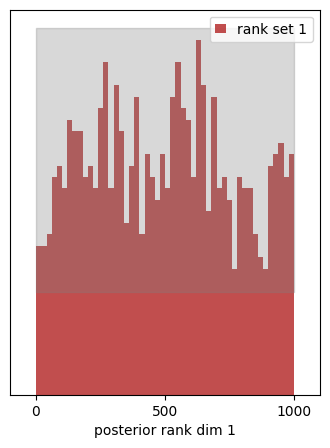

In [ ]:
f, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=1000,
    plot_type="hist",
    num_bins=50,  # by passing None we use a heuristic for the number of bins.
)